In [69]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [80]:
#seaborn 'colorblind' palette
c1,c3,c2,_,_,_,_ = clrs = mpl.rcParams['axes.color_cycle'] = \
[(0.0, 0.4470588235294118, 0.6980392156862745),
 (0.0, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.4745098039215686, 0.6549019607843137),
 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 array((106,65,47))/255.] #muted brown, not originally part of 'colorblind'

In [3]:
import cPickle as pickle
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter
import os.path as osp
from run_sim import planck, fidcl, Slik
import cosmoslik as K

In [7]:
r=dict(pickle.load(open("results/result_real_white_powell")))
for x in r.values():
    x['clTT']=x['clTT'][:2509]
    x['clTT_decal']=x['clTT']/x['calPlanck']**2
    x['cosmo.ommh2']+=0.06/94.

In [159]:
def read_minimum(f):
    return {k:float(v) for k,v in [array(l.split())[[2,1]] for l in open(f).readlines()[3:-5] if l.strip()]}

lmaxs=[999, 1197, 1296, 1404, 1503, 1605, 1809, 1996, 2310]

silviar={}
silviar.update({(2,lmax):read_minimum('lmax_minima/base_FIX_TTFGokCAMB_PCAL_PSZ_plik_dx11dr2_HM_v18_LMAX%i_TT_lowl_tauprior0702.minimum'%lmax) for lmax in lmaxs}) 
silviar.update({(30,lmax):read_minimum('lmax_minima/base_FIX_TTFGokCAMB_PCAL_PSZ_plik_dx11dr2_HM_v18_LMAX%i_TT_tauprior0702.minimum'%lmax) for lmax in lmaxs})

silviarff={}
silviarff.update({(2,lmax):read_minimum('lmax_minima/base_PCAL_PSZ_plik_dx11dr2_HM_v18_LMAX%i_TT_lowl_tauprior0702.minimum'%lmax) for lmax in lmaxs})
silviarff.update({(30,lmax):read_minimum('lmax_minima/base_PCAL_PSZ_plik_dx11dr2_HM_v18_LMAX%i_TT_tauprior0702.minimum'%lmax) for lmax in lmaxs})
    
name_mapping = {'cosmo.ommh2':'omegamh2',
                'cosmo.ombh2':'omegabh2',
                's8omm1/4':'s8omegamp25',
                'cosmo.omch2':'omegach2',
                'cosmo.H0':'H0',
                'cosmo.logA':'logA',
                'cosmo.theta':'theta',
                'cosmo.ns':'ns',
                'cosmo.tau':'tau'}

In [160]:
cme={k:K.utils.load_chain("chains/test_chain_%i_%i.chain"%k).burnin(3000).join()
     for k in [(2,2510),(2,2000),(2,1100),(800,2510),(1000,2510),(1200,2510)]}
for c in cme.values():
    c['cosmo.ommh2']=c['cosmo.ombh2']+c['cosmo.omch2']+0.06/94.
    
cali=K.chains.load_chain("chains/2tauP2500/test").burnin(5000).join()

In [163]:
params = [('cosmo.H0',r'$H_0$'),
          ('cosmo.ommh2',r'$\omega_m$'),          
          ('cosmo.ombh2',r'$\omega_b$'),
          
          ('cosmo.logA',r'$\log A$'),
          ('cosmo.ns',r'$n_s$'),
          ('cosmo.tau',r'$\tau$'),
        
          ('cosmo.theta',r'$\theta$'),
#           ('s8omm1/4',r'$\sigma_8 \Omega_m^{0.25}$'),
          ('cosmo.clamp',r'$A_s e^{-2\tau}$'),
          
          ('calPlanck','$y_p$'),
#           ('highl_chi2',r'$\chi^2$')
         ]


def mkplot(low=True,mid=True,high=True,
           smid_fgfree=False,slow_fgfree=False,
           smid_fgfix=False,slow_fgfix=False,
           chains=False):
    
    fig=figure()
    fig.set_size_inches(2*6,5*6/2)
    fig.subplots_adjust(hspace=0.1,wspace=0.3)


    for i,(n,pn) in enumerate(params):
        ax=subplot(5,2,i+1)

        if high:
            ells=range(100,1200,50); ells.remove(1100)
            plot(ells,[r[(lsplit,2510)][n] for lsplit in ells],'.-',c=c2,lw=1.5,markersize=6,
                 label=r'$(\ell_{\rm split},2500)$')  
        
        if low:
            ells=range(700,2500,50); #ells.remove(1100)
            plot(ells,[r[(2,lsplit)][n] for lsplit in ells],'.-',c=c1,lw=1.5,markersize=6, 
                 label=r'$(2,\ell_{\rm split})$')
        if mid:
            ells=range(700,2500,50); ells.remove(1100)
            plot(ells,[r[(30,lsplit)][n] for lsplit in ells],'--',c=c1,lw=1.5,markersize=6,
                 label=r'$(30,\ell_{\rm split})$')


        np=name_mapping.get(n,n).replace('*','')
        if np in silviar.values()[0]:
            if slow_fgfree:
                plot(lmaxs,[silviarff[(2,lsplit)][np] for lsplit in lmaxs],'r.-',
                     label=r'${\rm Plik \,} (2,\ell_{\rm split}) \, \rm fgs \, free$')                            
                
            if smid_fgfree:
                plot(lmaxs,[silviarff[(30,lsplit)][np] for lsplit in lmaxs],'r--',
                     label=r'${\rm Plik \,} (30,\ell_{\rm split}) \, \rm fgs \, free$')                            

            if slow_fgfix:
                plot(lmaxs,[silviar[(2,lsplit)][np] for lsplit in lmaxs],'g.-',
                     label=r'${\rm Plik \,} (2,\ell_{\rm split}) \, \rm fgs \, fixed$')                            
                
            if smid_fgfix:
                plot(lmaxs,[silviar[(30,lsplit)][np] for lsplit in lmaxs],'g--',
                     label=r'${\rm Plik \,} (30,\ell_{\rm split}) \, \rm fgs \, fixed$')                            

        lims=ax.get_ylim()        
                
        if chains:
            if n in cme.values()[0]:
                for l in [1100,2000,2510]:
                    errorbar([l],[cme[2,l].mean(n)],[cme[2,l].std(n)],c=c1,marker='.',ls='',label='')
                
                for l in [800,1000]:
                    errorbar([l],[cme[l,2510].mean(n)],[cme[l,2510].std(n)],c=c2,marker='.',ls='',label='')                
                
            np=name_mapping.get(n,n)
            if np in cali:
                errorbar([2520],[cali.mean(np)],[cali.std(np)],c='m',marker='.',ls='')

        if n=='highl_chi2':
            ells=range(700,2500,50); plot(ells,[r[(30,lsplit)]['highl_dof']-6 for lsplit in ells],'-.',c=c1,lw=1.5,markersize=6)
            ells=range(100,1700,50); plot(ells,[r[(lsplit,2510)]['highl_dof']-6 for lsplit in ells],'-.',c=c2,lw=1.5,markersize=6)

        ax.set_ylim(*lims)
        ax.set_xlim(0,2600)

        if 1<i<8:
            ax.set_xticklabels([])
        else:
            if i>8: xlabel(r'$\ell_{\rm split}$',size=20)
            if i<2: ax.tick_params(labelbottom='off',labeltop='on')
        ylabel(pn,size=20)  

        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(4))    
        ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

        if i==1: legend(ncol=3, loc='lower center', bbox_to_anchor=(-0.15, 1.1),prop={'size':20})

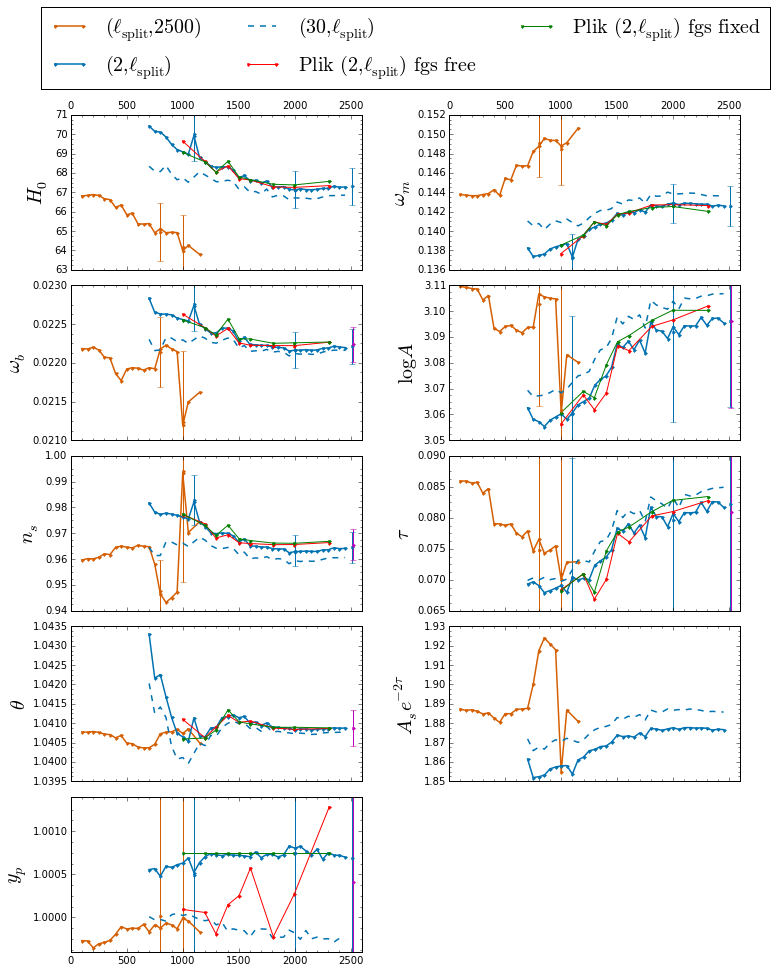

In [166]:
mkplot(slow_fgfree=True, slow_fgfix=True, chains=True)
savefig('plots/params_vs_lsplit_debug.pdf',bbox_inches='tight')

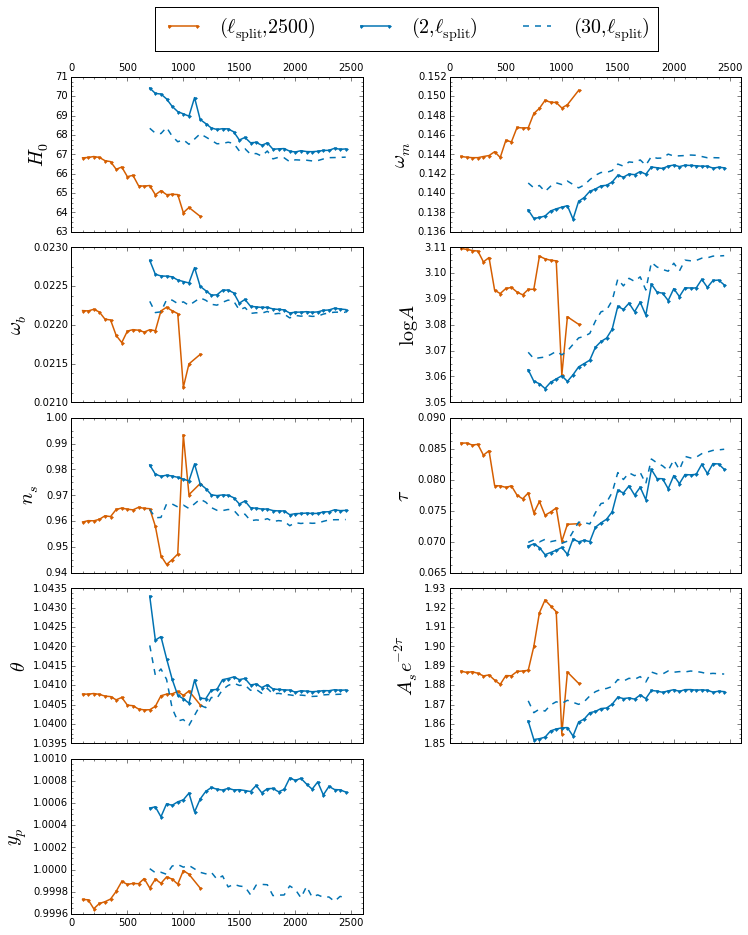

In [165]:
mkplot()
savefig('plots/params_vs_lsplit.pdf',bbox_inches='tight')

In [30]:
# ali=read_minimum('1400tauP.minimum')

In [32]:
in_lslice=slice(30,2509)
import struct
todl=arange(2509)*(arange(2509)+1)/2/pi

def load_cl(filename):
    return hstack([zeros(in_lslice.start),loadtxt(filename)[:,1]])*todl

def load_cov(filename):
    f=open(filename).read()
    cmbcov=zeros((2509,2509))
    start=in_lslice.start
    nl=in_lslice.stop - in_lslice.start
    cmbcov[start:,start:]=array(struct.unpack('d'*(len(f)/8-1),f[4:-4])).reshape((nl,nl))
    for i in arange(cmbcov.shape[0]):
        for j in arange(i):
            cmbcov[j,i]=cmbcov[i,j]
    return (cmbcov*todl).T*todl

pkcl = load_cl('cmbcls/cl_cmb_plik_bin1_v18.dat')
pkcv = load_cov('cmbcls/c_matrix_plik_bin1_v18.dat')

In [33]:
import mspec as M
import pyfits

# lims=hstack([arange(30,2509,99)])
lims=array([30]+range(100,2500,50)+[2509])
bin=M.get_bin_func('q',q=M.lims_to_q(zip(lims,lims[1:]-1)))

lowl=pyfits.open('COM_PowerSpect_CMB_R2.02.fits')[1].data

In [34]:
lmap=vectorize(lambda l, lpiv=100., lstretch=100.: lpiv+lstretch*log(l/lpiv) if l<lpiv else l)

In [35]:
dCls=pickle.load(open('dCls.dat'))
dCls['100theta']={k:v/100 for k,v in dCls['theta'].items()}
dCls['clamp']={k:v/100 for k,v in dCls['theta'].items()}

In [36]:
name_mapping={'cosmo.theta':'100theta',
              'cosmo.ommh2':'omegamh2*',
              'cosmo.ombh2':'ombh2',
              'cosmo.ns':'scalar_spectral_index(1)',
              'cosmo.clamp':'clamp*',
             'cosmo.tau':'re_optical_depth'}

In [37]:
def boxerrs(lmins,lmaxs,ys,errs,lrange,dl=6,**kwargs):
    for (lmin,lmax,y,err) in zip(lmins,lmaxs,ys,errs):
        fill_between(lmap((lmin+dl,lmax-dl)),[y-err]*2,[y+err]*2,
                     facecolor='darkgray' if lmax<=lrange[1] else 'lightgray',edgecolor='dimgray',lw=0.5,**kwargs)

In [113]:
color_map = [
#              ('clamp*',clrs[2]),
#              ('scalar_spectral_index(1)',clrs[2]),    
             ('re_optical_depth',clrs[5],r'$\tau$'),
             ('ombh2',clrs[3],r'$\omega_b$'),
             ('100theta',clrs[0],r'$\theta$'),
             ('omegamh2*',clrs[1],r'$\omega_m$'),        
             ('ampns',clrs[2],r'$A_s e^{-2\tau},n_s$')
            ]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in divide


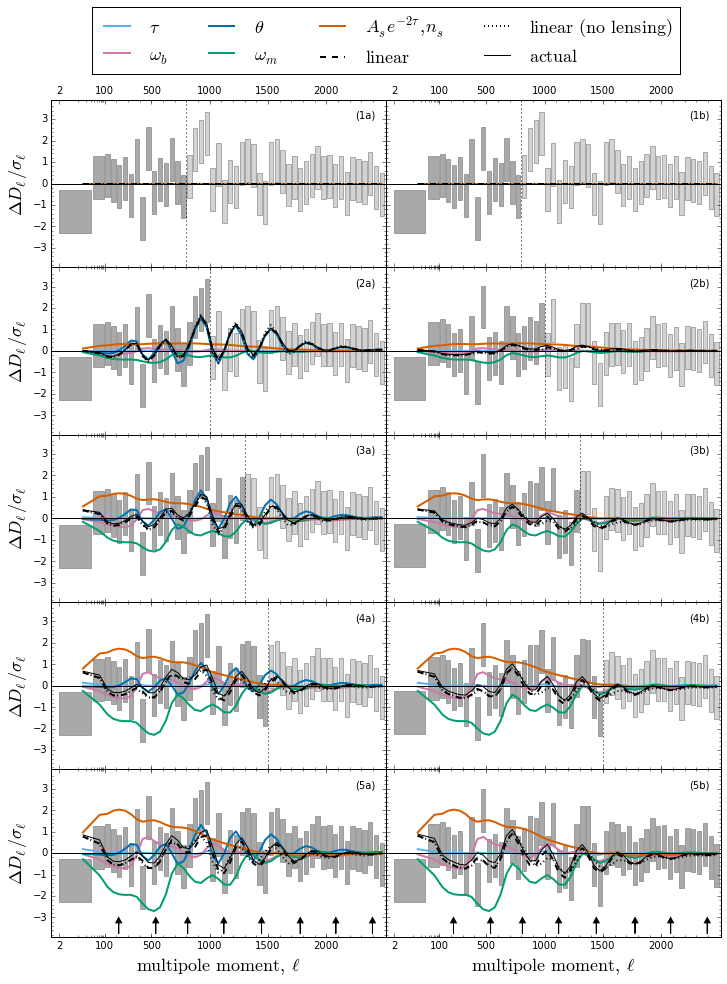

In [138]:
fig=figure()
fig.set_size_inches(2*6,4*6/1.6)
fig.subplots_adjust(hspace=0,wspace=0)

lims=array([2,30]+range(100,2500,50)+[2500])
# lims=array([2,30]+range(100,850,50)+[2500])
# lims=array([2,30]+range(100,850,50)+[1000,2500])
bin=M.get_bin_func('q',q=M.lims_to_q(zip(lims,lims[1:]-1)))

r2=r[2,800]
fid=r2['clTT']
todl=arange(2509)*(arange(2509)+1)/2/pi

for j in [0,1]:
    for i,lmax in enumerate([800,1000,1300,1500,2510]):

        r1=r[2,lmax]
        subplot(5,2,2*i+j+1)

        y=lowl['D_ELL'].mean() - (fid*todl)[2:30].mean(); err=1/sqrt(sum(1/lowl['ERRUP']**2))        
        dfac=hstack([[err],sqrt(diag(bin(pkcv)))[1:]])

        dCl={k2:dCls[k2]['lensed_TT'][:2510]*(r1[k1] - r2[k1]) for k1,k2 in name_mapping.items()}
        dClscalar={k2:dCls[k2]['scalar_TT'][:2510]*(r1[k1] - r2[k1]) for k1,k2 in name_mapping.items()}

        fid=r2['clTT']
        
        dCl['ampns']=dCl.pop('clamp*')+dCl.pop('scalar_spectral_index(1)')
        dClscalar['ampns']=dClscalar.pop('clamp*')+dClscalar.pop('scalar_spectral_index(1)')
        
        if j==1:
            fid=hstack([zeros(2),r2['clTT'][2:] + dCl.pop('100theta')[2:2509]/todl[2:]])
            dClscalar.pop('100theta')


        for k2,c,l in color_map:
            if k2 in dCl:
                plot(lmap(bin(arange(2509))),bin(dCl[k2])/dfac,lw=2,label=l,c=c)


        plot(lmap(bin(arange(2510))),bin(sum(dCl.values(),axis=0))/dfac,'k--',lw=2,label=r'$\rm linear$')
        plot(lmap(bin(arange(2509))),bin(sum(dClscalar.values(),axis=0))/dfac,'k:',lw=2,label=r'$\rm linear \,(no \,lensing)$')
        plot(lmap(bin(arange(2510))),bin(((r1['clTT'] - fid)*todl))/dfac,'k',lw=1,label=r'$\rm actual$')


        fill_between(lmap([2,30]),[y/err-1]*2,[y/err+1]*2,facecolor='darkgray',edgecolor='dimgray',lw=0.5)
        boxerrs(bin.lmins[1:],bin.lmaxs[1:],(bin(pkcl-fid*todl)/sqrt(diag(bin(pkcv))))[1:],ones(bin(arange(30,2510)).size), (2,lmax))

        plot([lmax]*2,[-200,200],'k:')

        plot(lmap([1,2509]),[0]*2,'k',zorder=100)


        if i==0 and j==0: legend(loc='lower center', bbox_to_anchor=(1, 1.1),ncol=4,prop=dict(size=18))
        ticks=[2,100]+range(500,2500,500)
        ax=gca()
        ax.set_xticks(lmap(ticks))
        ax.set_xticks(lmap(range(10,100,10)+range(100,2500,100)),minor=True);

        ax.set_xticklabels(ticks)
        if i==0: ax.tick_params(labelbottom='off',labeltop='on')
        elif i==4: ax.set_xlabel(r'${\rm multipole \, moment,}\,\ell$',size=18)
        else: ax.set_xticklabels([])

        if j==0: ax.set_ylabel(r'$\Delta D_\ell/\sigma_\ell$',size=18)        
        else: ax.set_yticklabels([])

        ax.yaxis.set_minor_locator(AutoMinorLocator(5))    

        text(2250,3,'(%i%s)'%(i+1,'ab'[j]))
        ylim(-3.9,3.9)
        xlim(lmap(1),lmap(2509))
        
        if i==4:
            for p in [220,537.5,810.8,1120.9,1444.2,1776,2081,2395]:
                ax.arrow(p, -3.75, 0, 0.5, head_width=50, head_length=0.25, fc='k', ec='k')


savefig('plots/bestfit_shift_components_scaled_twocol.pdf',bbox_inches='tight')